# Epistemic loss as a function of training epoch

In [27]:
from scripts import train, models, analysis, io
import torch
import matplotlib.pyplot as plt

First initialize the model.

In [20]:
DER_type = 'SDER'
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)
DEVICE = get_best_device()
model, _ = train.model_setup_DER(DER_type, DEVICE)

In [32]:
def load_model_checkpoint(model, DER_type, epoch, device, path='../models/'):
    """
    Load PyTorch model checkpoint from a .pt file.

    :param path: Location to load the model from
    :param DER_type: Type of your model
    :param epoch: Epoch to load
    :param device: Device to load the model onto ('cuda' or 'cpu')
    :param model: PyTorch model to load the checkpoint into
    :return: Loaded model
    """
    file_name = f"{path}/{DER_type}_{epoch}.pt"
    
    checkpoint = torch.load(file_name, map_location=device)
    
    # Handle the case where extra information is present in the state_dict
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    # Extract additional information
    loaded_epoch = checkpoint.get('epoch', None)
    med_u_ep_validation = checkpoint.get('med_u_ep_validation', None)
    med_u_al_validation = checkpoint.get('med_u_al_validation', None)

    return model, loaded_epoch, med_u_ep_validation, med_u_al_validation

In [22]:
loadmodel, epoch, ep, al = load_model_checkpoint(model, DER_type, 1, DEVICE)

In [23]:
print(loadmodel, epoch, ep)

Sequential(
  (0): Model(
    (model): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (1): SDERLayer()
) 1 18.928104


In [24]:
# now make a loop over all epochs available for the model
import os
print(os.listdir('../models/'))

['SDER_22.pt', 'SDER_16.pt', 'SDER_47.pt', 'SDER_32.pt', 'SDER_43.pt', 'SDER_12.pt', 'SDER_26.pt', 'SDER_36.pt', 'SDER_42.pt', 'SDER_13.pt', 'SDER_27.pt', 'SDER_37.pt', 'SDER_23.pt', 'SDER_17.pt', 'SDER_46.pt', 'SDER_33.pt', 'SDER_28.pt', 'SDER_38.pt', 'SDER_1.pt', 'SDER_49.pt', 'SDER_18.pt', 'SDER_5.pt', 'SDER_48.pt', 'SDER_19.pt', 'SDER_4.pt', 'SDER_29.pt', 'SDER_39.pt', 'SDER_0.pt', 'SDER_7.pt', 'SDER_3.pt', 'SDER_2.pt', 'SDER_6.pt', 'SDER_10.pt', 'SDER_41.pt', 'SDER_24.pt', 'SDER_34.pt', 'SDER_20.pt', 'SDER_45.pt', 'SDER_14.pt', 'SDER_9.pt', 'SDER_30.pt', 'SDER_21.pt', 'SDER_44.pt', 'SDER_15.pt', 'SDER_8.pt', 'SDER_31.pt', 'SDER_11.pt', 'SDER_40.pt', 'SDER_25.pt', 'SDER_35.pt']


In [34]:
ep = []
al = []
for e in range(50):
    _, _, epistemic, aleatoric = load_model_checkpoint(model, DER_type, e, DEVICE)
    ep.append(epistemic)
    al.append(aleatoric)
    

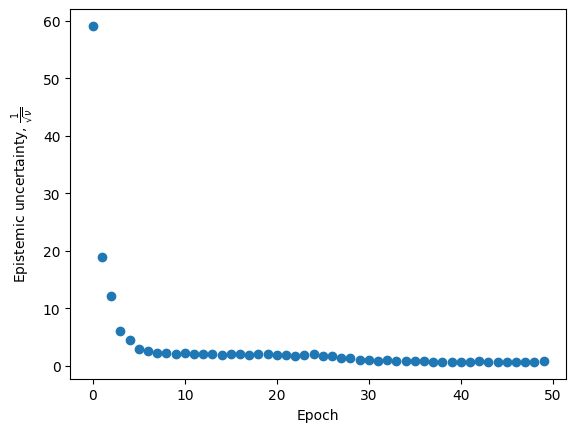

In [31]:
plt.clf()
plt.scatter(range(50), ep)
plt.ylabel(r'Epistemic uncertainty, $\frac{1}{\sqrt{\nu}}$')
plt.xlabel('Epoch')
plt.show()

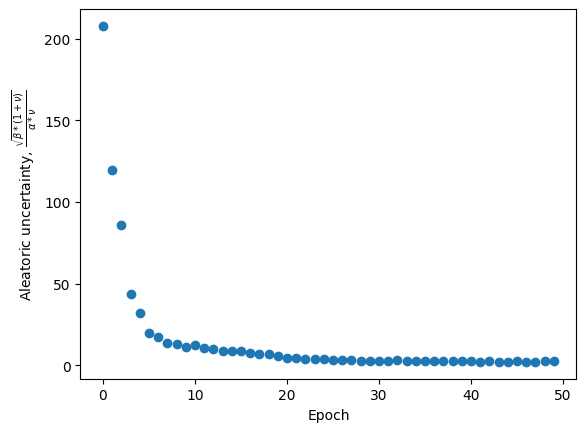

'\nu_al = np.sqrt(beta.detach().numpy() * (1 + nu.detach().numpy()) /\n                   (alpha.detach().numpy() * nu.detach().numpy()))\n   \n'

In [36]:
plt.clf()
plt.scatter(range(50), al)
plt.ylabel(r'Aleatoric uncertainty, $\frac{\sqrt{\beta * (1 + \nu)}}{\alpha * \nu}$')
plt.xlabel('Epoch')
plt.show()


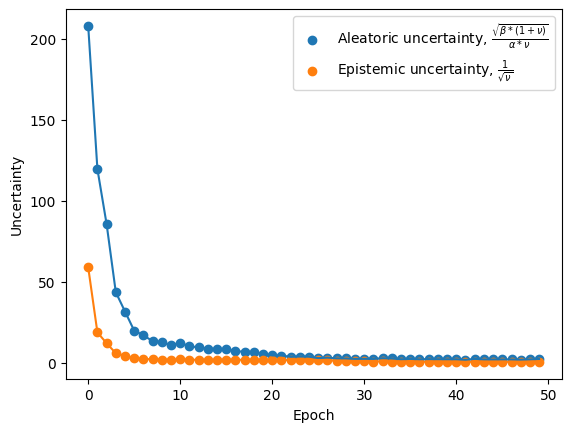

In [43]:
# overplot both
plt.clf()
plt.plot(range(50), al)
plt.plot(range(50), ep)
plt.scatter(range(50), al, label = r'Aleatoric uncertainty, $\frac{\sqrt{\beta * (1 + \nu)}}{\alpha * \nu}$')
plt.scatter(range(50), ep, label = r'Epistemic uncertainty, $\frac{1}{\sqrt{\nu}}$')

plt.legend()
plt.ylabel('Uncertainty')
plt.xlabel('Epoch')
plt.show()
